# Cooperativity Sites
miRNA bind to target mRNA through target 'sites'. These sites can be 8mer, 7mer, or 6mer. Given a certain site and a set range (referred to as the Cooperativity Range), we wish to measure the number of nearby sites and the miRNA corresponing to that site. 

To do this, I will take human/zebrafish genome information and do a site search for each miRNA seed. For each miRNA seed, I will save the locations of targets.

I have to decide how I will save location. It needs to be in a way such that location lookup is fast. 


In [296]:
import pandas as pd
from numpy import loadtxt
from ast import literal_eval
import matplotlib.pyplot as plt
DELIMITER = "_"


In [88]:
#loading the variables we need
zebrafish_genes = loadtxt("data/zebrafish_genes.txt", comments=">",dtype="str")
zebrafish_genes = [i for i in zebrafish_genes if i != "sequence_unavailable"]
zebrafish_mirna = pd.read_csv("data/mirna_zebrafish.csv")[['Family', 'Seed']]

/var/folders/wd/wcjpwvbx6ql2slnp2p7cvn2m0000gn/T/ipykernel_977/1706238058.py:2: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  zebrafish_genes = loadtxt("data/zebrafish_genes.txt", comments=">",dtype="str")


# Method for Data Structure
Example:

miRNA: id1-AAG-3, id2-GAG-3, id3-AG-2

Sequence: AAGAGCTTAG 

So for seed 

id1-AAG-3:*AAG*AG*AAG*CTTAG 

id2-GAG-2:AA*GAG*AAGCTTAG 

id3-AG-2:A*AG**AG*A*AG*CTT*AG *

And we’d make a list like this

[‘A’:[id1-AAG-3],

’A’:[id1-AAG-3, id3-AG-2],

’G’:[id1-AAG-3,id3-AG-2, id2-GAG-2],

’A’:[id3-AG-2, id2-GAG-2],

’G’:[id3-AG-2, id2-GAG-2],

’A’:[id1-AAG-3],

’A’:[id1-AAG-3,id3-AG-2],

’G’:[id1-AAG-3,id3-AG-2],

’C’:[],

’T’:[],

’T’:[],

’A’:[id3-AG-2],

’G’:[id3-AG-2]]


This if we wanted to find all the target seed in range n to GAG at index 2-4, we’d just look at the elements in range (index-n, index+n). 
The good thing about this is it’s fast and it can hold a lot of useful information: the id can contain the name, family, seed and length of a miRNA. However, the issue is with counting. What i could do it something like this:

miRNA-id = name-seed-family-length-occurrence. 

That way, each target site has it’s own unique label, so I can just do look up and then turn the list into a set, removing repeats.


In [111]:
def compliment(seed):
    seed = seed.replace('A', 'X')
    seed = seed.replace('U', 'A')
    seed = seed.replace('X', 'T')
    seed = seed.replace('C', 'X')
    seed = seed.replace('G', 'C')
    seed = seed.replace('X', 'G')
    return seed

def get_targets(seed, target_type):
    match(target_type):
        case '6mer':
            seed = compliment(seed[1:8][::-1])
        case '7mera':
            seed = compliment(seed[1:8][::-1])+"A"
        case '7mer':
            seed = compliment(seed[0:8][::-1])
        case '8mer':
            seed = compliment(seed[0:8][::-1])+"A"
        case _:
            seed = None
    return seed

def get_ids(mirna_df):
    #we need a list of ids: name-target-family-length-occurrence
    mirna_list = []
    for index, row in mirna_df.iterrows():
        mirna_list.append((row['Family'],row['Seed']))
    mirna_list = list(set(mirna_list))
    #for each mirna, make an id: name-seed-target(6mer,7a,7,8)-target_type
    ids = []
    for family,base_seed in mirna_list:
        for target_type in ['6mer','7mera','7mer','8mer']:
            target = get_targets(base_seed, target_type)
            ids.append(family+DELIMITER+base_seed+DELIMITER+target+DELIMITER+target_type)
    return ids

In [247]:
#for one gene, make the data_table
def get_gene_table( gene, ids, sgdf, sg_file):
    if gene in sgdf["gene"].values:
        row = sgdf.loc[sgdf['gene'] == gene]
        gene_table = list(row["gene_table"].apply(literal_eval))[0]
        targets = list(row['targets'].apply(literal_eval))[0]
        locations = list(row['locations'].apply(literal_eval))[0]
        return gene_table, dict(zip(targets, locations))
    else:
        loc_dict = {}
        gene_table = [[] for i in gene]
        for id in ids:
            target = id.split(DELIMITER)[2]
            occurance_count = 0
            # Find the starting index of target in gene, if target exists as a subsequence.
            for i in range(len(gene) - len(target) + 1):
                if gene[i:i + len(target)] == target:
                    occurance_count+=1
                    if id in loc_dict:
                        loc_dict[id].append(i)
                    else:
                        loc_dict[id] = [i]
                    # Update gene_table with ids at the corresponding indices.
                    for j in range(len(target)):
                        gene_table[i + j].append(id+DELIMITER+str(occurance_count))
        #add to saved genes
        print("saving to df")
        targets = list(loc_dict.keys())
        locations = list(loc_dict.values())
        sgdf.loc[len(sgdf)] = [gene,gene_table, targets, locations]
        sgdf.to_csv(sg_file, index = False)
        return gene_table, loc_dict


In [300]:
def count_neighbors(gene_table, index, distance, filters):
    #given a gene table, index, and distance, counts the number of targets within 'distance' nucleotides down the sequence
    #neighbors = downstream targets
    if index+distance<len(gene_table):
        target_list = [item for sublist in gene_table[index:index+distance] for item in sublist]
        targets = set(target_list)
        targets = [target for target in targets if any(fil in target for fil in filters)]
        return len(targets)
    else:
        #if distance goes past the length of the gene, just count whatever is there
        distance = len(gene_table)-index
        target_list = [item for sublist in gene_table[index:index+distance] for item in sublist]
        targets = set(target_list)
        targets = [target for target in targets if any(fil in target for fil in filters)]
        return len(targets)


In [332]:
def get_targets_for_range(start,end,genes,mirna, sgdf, sg_file, filters):
    data_dict = {}

    for gene in genes:
        gene_table, loc_dict = get_gene_table(gene, get_ids(mirna), sgdf, sg_file)
        
        for distance in range(start,end):
            num_targets = 0
            total_neighbors = 0
            for key in loc_dict.keys():
                for index in loc_dict[key]:
                    seed = key.split(DELIMITER)[2]
                    count_targets = count_neighbors(gene_table, index+len(seed), distance, filters)
                    if count_targets != None:
                        num_targets+=1
                        total_neighbors += count_targets
            if num_targets == 0:
                data_dict[distance] = 0
            else:
                if distance in data_dict:
                    data_dict[distance] += total_neighbors/num_targets
                else:
                    data_dict[distance] = total_neighbors/num_targets
    for key in data_dict.keys():
        data_dict[key] = data_dict[key]/len(genes)
    return data_dict

In [334]:
def plot_distance(distance_dict):
    #given a distance dict, plot
    x = distance_dict.keys()
    y = distance_dict.values()
    plt.xlabel('distance')
    plt.ylabel('# target sites')
    plt.plot(x,y, label = "acc targets")
    plt.show()
    
def plot_diff_dist(distance_dict):
    diff_x = list(distance_dict.keys())[1:]
    diff_y = list(distance_dict.values())
    diff_y = [diff_y[i + 1] - diff_y[i] for i in range(len(diff_y) - 1)]

    plt.xlabel('distance')
    plt.ylabel('# target sites')
    plt.plot(diff_x,diff_y, label = "diff targets")
    plt.show()


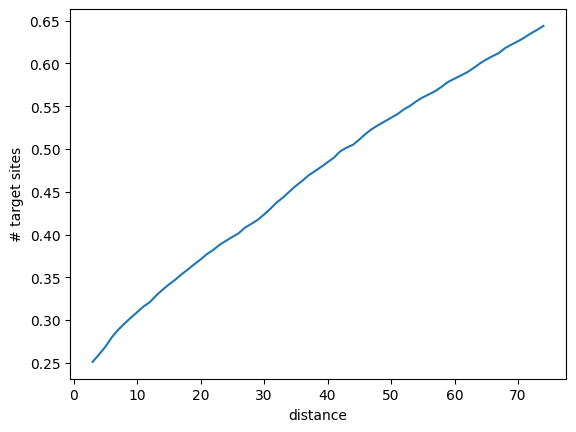

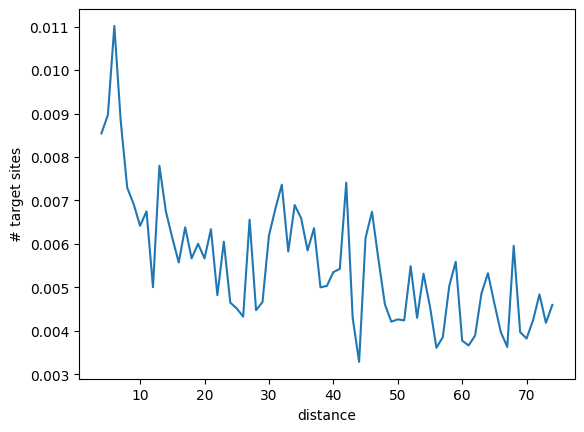

In [337]:
sg_file = "data/zebrafish_sg.csv"
sgdf = pd.read_csv(sg_file)
filters = [['8mer'], [], [], []]

distance_dict = get_targets_for_range(1,75,
                                      zebrafish_genes[0:500], 
                                      zebrafish_mirna, 
                                      sgdf, 
                                      sg_file, 
                                      filters)
plot_distance(distance_dict)
plot_diff_dist(distance_dict)